## Tapping Playground

This notebooks investigates optimal hand- and fingertapping algorithms as part of the 
ReTune-Dyskinesia project.



### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import stats
from array import array
import datetime
import h5py
from dataclasses import  dataclass, field

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')
rawdatapath = '/Users/jeroenhabets/OneDrive - Charité - Universitätsmedizin Berlin/BIDS_Berlin_ECOG_LFP/rawdata'
proc_data_path = os.path.join(projectpath, 'data/preprocess')
# change working directory to project-code folder
os.chdir(projectpath)
temp_save = os.path.join(projectpath, 'figures/TEMP')
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'

In [81]:
os.chdir(codepath)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
# own data exploration functions
import lfpecog_features.feats_read_data as read_data
import lfpecog_features.handTap_detect as handTap_detect
import lfpecog_features.handTap_detect2 as tap

import lfpecog_preproc.preproc_resample as resample

os.chdir(projectpath)




## ACC CHECK Johannes

In [11]:
@dataclass(init=True, repr=True, )
class accData:
    """
    Store Acc data
    """
    # give at initiation
    OnFile: str = field(default_factory=str)
    OffFile: str = field(default_factory=str)
    # create after initiation
    On=[]
    Off=[]

    def __post_init__(self,):
        self.On = scipy.io.loadmat(self.OnFile)
        self.Off = scipy.io.loadmat(self.OffFile)


In [45]:
for key in list(acc['tAccStimTap']):
    print(key, (list(acc['tAccStimTap'][key])), '\n')

cfg ['callinfo', 'channel', 'checkpath', 'frequency', 'latency', 'nanmean', 'outputfilepresent', 'previous', 'progress', 'select', 'tolerance', 'toolbox', 'trackmeminfo', 'tracktimeinfo', 'trials', 'version'] 

fsample [array([4000.])] 

hdr ['Fs', 'chantype', 'chanunit', 'label', 'nChans', 'nSamples', 'nSamplesPre', 'nTrials'] 

label [array([<HDF5 object reference>], dtype=object)] 

sampleinfo [array([831097.]), array([959097.])] 

time [array([<HDF5 object reference>], dtype=object)] 

trial [array([<HDF5 object reference>], dtype=object)] 



In [47]:
list(acc['tAccStimTap']['trial'])

[array([<HDF5 object reference>], dtype=object)]

In [26]:
import fieldtrip2mne as f2m
import mne

In [213]:
dlFolder = '/Users/jeroenhabets/Downloads'
matfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'mat']
# print(matfiles)

for f in matfiles:
    if '540AE' in f:
        if 'On' in f: f_40on = os.path.join(dlFolder, f)
        if 'Off' in f: f_40off = os.path.join(dlFolder, f)

    if '537BI' in f:
        if 'On' in f: f_37on = os.path.join(dlFolder, f)
        if 'Off' in f: f_37off = os.path.join(dlFolder, f)

# try: 
#     acc = scipy.io.loadmat(onF)
# except NotImplementedError:
#     acc = h5py.File(onF, 'a')


# acc = acc.T
# svm = np.sqrt(acc[0, :]**2 + acc[1, :]**2 + acc[2, :]**2)
# acc = np.vstack((acc, svm))
# print(acc.shape)
fs = 250


In [217]:
dlFolder = '/Users/jeroenhabets/Downloads'
csvfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'csv']

for f in csvfiles:
    if '540AE' in f:
        if 'On' in f: f_40on = os.path.join(dlFolder, f)
        if 'Off' in f: f_40off = os.path.join(dlFolder, f)

    if '537BI' in f:
        if 'On' in f: f_37on = os.path.join(dlFolder, f)
        if 'Off' in f: f_37off = os.path.join(dlFolder, f)


file = open(f_40on, 'rb')
acc40on = np.loadtxt(file,delimiter = ",")
file = open(f_37off, 'rb')
acc37off = np.loadtxt(file,delimiter = ",")

In [224]:
importlib.reload(resample)

or_fs = 4000

acc40on = signal.resample(
    acc40on,
    (acc40on.shape[0] // (or_fs // fs)),
)

acc37off = signal.resample(
    acc37off,
    (acc37off.shape[0] // (or_fs // fs)),
)

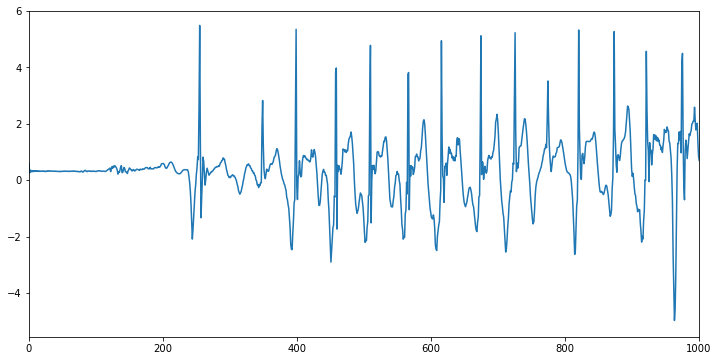

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(-acc37off)
ax.set_xlim(0, 1000)
plt.show()

In [205]:
importlib.reload(tap)
taps40on = tap.tapDetector(
    x=acc40on, y=acc40on, z=acc40on, task='continuous', fs=250,
)

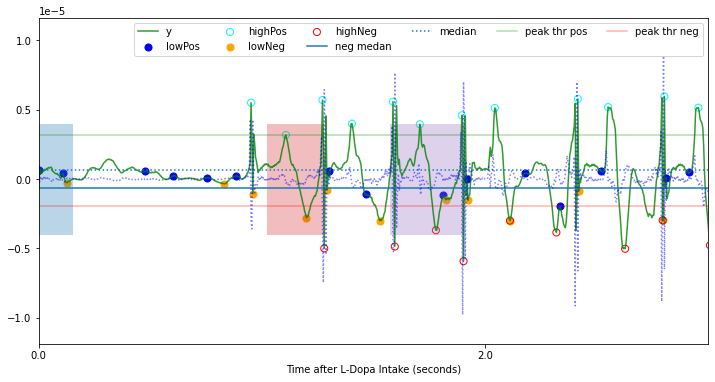

In [299]:
# Find peaks to help movement detection

sig=acc40on * 1e-6
fs=250
settings = {
    'continuous': {
        'peak_dist': 0.1,
    },
    'paused': {
        'peak_dist': .5,
    }
}
task = 'continuous'
smallPos = signal.find_peaks(
    sig,
    # height=(np.max(sig) * .1, np.max(sig) * .6),  # first value is min, second is max
    height=(-np.max(sig) * .5, np.max(sig) * .1),
    distance=fs * settings[task]['peak_dist'],
    # prominence=np.max(sig) * .1,
    # wlen=fs * settings[task]['peak_dist'],
)
largePos = signal.find_peaks(
    sig,
    height=np.max(sig) * .3,
    distance=fs * settings[task]['peak_dist'],  # 1 s
)
smallNeg = signal.find_peaks(
    -1 * sig,  # convert pos/neg for negative peaks
    height=(-.5e-7, abs(np.min(sig)) * .5),
    distance=fs * settings[task]['peak_dist'] * .5,
    prominence=abs(np.min(sig)) * .05,
    # wlen=40,
)
largeNeg = signal.find_peaks(
    -1 * sig,
    height=abs(np.min(sig)) * .4,  # first value is min, second is max
    distance=fs * settings[task]['peak_dist'],
    # prominence=np.min(yEpoch) * .1,
    # wlen=40,
)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(sig, label='y', alpha=.8, c='green')

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
col_pms = [
    {'color': 'blue',},
    {'color': 'none', 'edgecolor': 'cyan'},
    {'color': 'orange'},
    {'edgecolor': 'red', 'facecolor': 'none',}
]
peakcol = ['blue', 'green', 'orange', 'red']

for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        sig[peaks[0]],
        label=peaklabel[p],
        s=50,
        **col_pms[p],
    )

for tapi in taps40on[1]:
    ax.fill_betweenx(
        y=np.linspace(-4e-6, 4e-6, 5),
        x1=tapi[0] * 250,
        x2=tapi[-1] * 250,
        alpha=.3,)

# ax.axhline(np.max(sig) * .5, label='.5 * MAX')
xticks = np.linspace(0, sig.shape[0], 17)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks / fs)
ax.set_xlabel('Time after L-Dopa Intake (seconds)')
# ax.axhline(1e-7, label='THR pos', c='green', alpha=.3)
# ax.axhline(-1e-7, label='THR neg', c='r', alpha=.3) 
ax.axhline(-np.median(sig), label='neg median')
ax.axhline(np.median(sig), label='median', ls='dotted')
ax.axhline(
    np.max(sig) * .5,
    label='peak thr pos', c='green', alpha=.3)
ax.axhline(
    np.min(sig) * .3,
    label='peak thr neg', c='r', alpha=.3,
)
ax.legend(ncol=6)
ax.set_xlim(0, 750)

ax.plot(np.diff(sig), c='b', ls='dotted', alpha=.5,)
plt.show()


In [314]:
# 4308, 4271
np.logical_and(
    any(sigdf[4300 : 4320] < -1e-6),
    any(sigdf[4300 : 4320] > 1e-6)
)

True

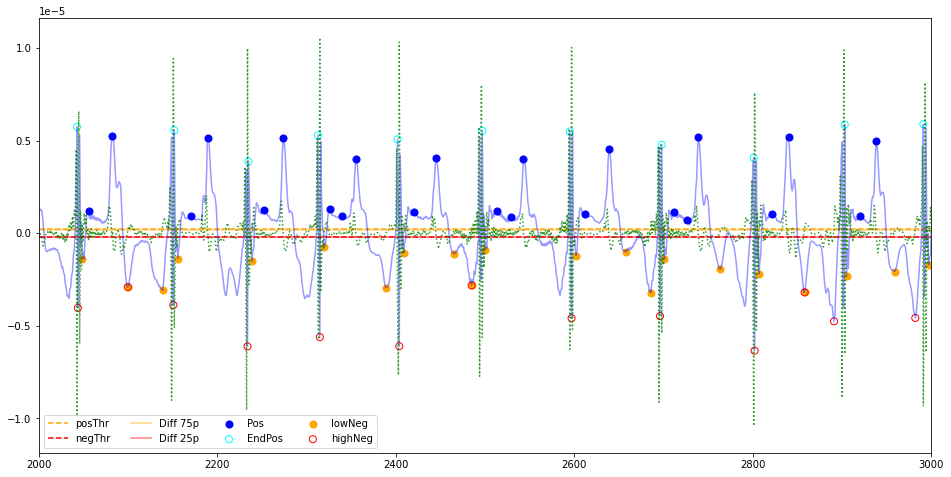

In [451]:
# sig = -acc37off * 1e-6
sig = acc40on * 1e-6


sigdf = np.diff(sig)
posThr = np.mean(sig)
negThr = -np.mean(sig)
# smallPos = signal.find_peaks(
#     sig,
#     # height=(np.max(sig) * .1, np.max(sig) * .6),  # first value is min, second is max
#     height=(-np.max(sig) * .5, np.max(sig) * .1),
#     distance=fs * settings[task]['peak_dist'],
#     # prominence=np.max(sig) * .1,
#     # wlen=fs * settings[task]['peak_dist'],
# )
# largePos = signal.find_peaks(
#     sig,
#     height=np.max(sig) * .3,
#     distance=fs * settings[task]['peak_dist'],  # 1 s
# )
# find relevant positive peaks
posPeaks = signal.find_peaks(
    sig,
    height=(posThr, np.max(sig)),
    distance=fs * .05,  # settings[task]['peak_dist']
)[0]
# select Pos-peaks with surrounding >> Pos and Neg Diff
endPeaks = [np.logical_or(
    any(sigdf[i -3:i + 3] < np.percentile(sig, 10)),  #np.percentile(sig, 90) * .5)
    any(sigdf[i -3:i + 3] > np.percentile(sig, 90))
) for i in posPeaks]
endPeaks = posPeaks[endPeaks]
# delete endPeaks from posPeaks
for i in endPeaks:
    idel = np.where(posPeaks == i)
    posPeaks = np.delete(posPeaks, idel)
# delete endPeaks which are too close after each other
# by starting with std False before np.diff, the diff-scores
# represent the distance to the previous peak
tooclose = endPeaks[np.append(
    np.array(False), np.diff(endPeaks) < (fs / 6))]
for p in tooclose:
    i = np.where(endPeaks == p)
    endPeaks = np.delete(endPeaks, i)
    posPeaks = np.append(posPeaks, p)

smallNeg = signal.find_peaks(
    -1 * sig,  # convert pos/neg for negative peaks
    height=(-.5e-7, abs(np.min(sig)) * .5),
    distance=fs * settings[task]['peak_dist'] * .5,
    prominence=abs(np.min(sig)) * .05,
    # wlen=40,
)[0]

largeNeg = signal.find_peaks(
    -1 * sig,
    height=abs(np.min(sig)) * .4,  # first value is min, second is max
    distance=fs * settings[task]['peak_dist'],
    # prominence=np.min(yEpoch) * .1,
    # wlen=40,
)[0]

fig, ax =plt.subplots(1,1, figsize=(16, 8))
ax.axhline(np.mean(sig), label='posThr', c='orange', ls='dashed')
ax.axhline(-np.mean(sig), label='negThr', ls='dashed', c='r')
ax.axhline(np.percentile(sigdf, 75), label='Diff 75p', c='orange', ls='solid', alpha=.5,)
ax.axhline(np.percentile(sigdf, 25), label='Diff 25p', ls='solid', c='r', alpha=.5,)

# ax.axhline(np.percentile(sig, 90), label='PERC-90', c='orange', ls='dotted')
# ax.axhline(np.percentile(sig, 10), label='PERC-10', c='red', ls='dotted')

ax.plot(sig, c='b', alpha=.4)
ax.plot(np.diff(sig), c='green', ls='dotted', alpha=.8)

peaklabel = ['Pos', 'EndPos', 'lowNeg', 'highNeg']
for p, peaks in enumerate([posPeaks, endPeaks, smallNeg, largeNeg]):
    ax.scatter(
        peaks,
        sig[peaks],
        label=peaklabel[p],
        s=50,
        **col_pms[p],
    )

ax.set_xlim(2000, 3000)
plt.legend(ncol=4)

plt.show()


In [436]:
for dat, pt in zip(
    [acc40on, -acc37off], ['40on', '37off']):
    print(f'{pt}:\n')
    print(f'Variation acc: {stats.variation(dat)}')
    print(f'Variation diff: {stats.variation(np.diff(dat))}')
    print()

40on:

Variation acc: 9.158406671094944
Variation diff: -6790.047554944627

37off:

Variation acc: 2.2714890805772376
Variation diff: 15292.591926845476



## ACC CHECK BARBARA

In [286]:
dlFolder = '/Users/jeroenhabets/Downloads'
matfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'mat']
print(matfiles)

acc = scipy.io.loadmat(os.path.join(dlFolder, matfiles[0]))['jeroen']  # Fs 250 Hz
acc = acc.T
svm = np.sqrt(acc[0, :]**2 + acc[1, :]**2 + acc[2, :]**2)
acc = np.vstack((acc, svm))
print(acc.shape)
fs = 250


['jeroenmatex.mat', 'ffraradspmeeg_Sub-015_12mfu_MOnSoff_BStr_FTRU_LSTN-20220125T132039.mat']
(4, 240313)


#### Descriptives

In [287]:
names = ['X', 'Y', 'Z', 'SVM']
for i in [0, 1, 2, 3]:
    print(f'AXIS: {names[i]}')
    print(f'Coef of Variation axis {i}: {stats.variation(acc[i, :])}')
    print(f'Median axis {i}: {np.median(acc[i, :])}')
    print(f'Mean axis {i}: {np.mean(acc[i, :])}')
    print(f'Std dev axis {i}: {np.std(acc[i, :])}\n')

AXIS: X
Coef of Variation axis 0: 321381.59409897134
Median axis 0: 0.00013248369214124978
Mean axis 0: 8.256683701341091e-07
Std dev axis 0: 0.2653546169907995

AXIS: Y
Coef of Variation axis 1: -370494.9105419953
Median axis 1: 7.643438584636897e-05
Mean axis 1: -1.7842968783443504e-06
Std dev axis 1: 0.6610729123225516

AXIS: Z
Coef of Variation axis 2: -1484214.2117369594
Median axis 2: -2.061223085547681e-06
Mean axis 2: -2.2165861141118768e-07
Std dev axis 2: 0.3289888612103649

AXIS: SVM
Coef of Variation axis 3: 2.389134896541549
Median axis 3: 0.010657566797215568
Mean axis 3: 0.3029538785770867
Std dev axis 3: 0.723797683351129



#### Peak Detection Epochs 0 and 1

In [522]:
for i in range(10):
        print(np.diff([epoch1[3956 + i], epoch1[3956 + i + 1]]))

[-3.89066702]
[-2.20191675]
[1.03659394]
[0.55430773]
[0.15000268]
[-0.29024918]
[0.23309027]
[0.21614496]
[0.17710242]
[0.0300526]


In [649]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
clrs=['green', 'orange', 'cyan']
dirs=[1, -1]
epoch1 = acc[1, fs * 50:fs * 75]
svm1 = acc[3, fs * 50:fs * 75]

states = np.zeros((len(epoch1)))

ax.plot(epoch1)
ax.plot(svm1, color='r', alpha=.2)

# find artefacts
art_i=[]
artf = signal.find_peaks(
    epoch1,
    # height=np.max(epoch1) * .5,
    width=(1, 5),
    rel_height=.3,
    distance=fs * 0.2,  # 10 ms
    prominence=np.max(epoch1) * .5,
    wlen=25,
)
print('artfeacts',len(artf[0]))
# for i in artf[0]:  # incl only sharp artf (slope > .5 max)
#     if  epoch1[i] - epoch1[i + 1] > np.max(epoch1) * .3:
#         art_i.append(i)

highPos = signal.find_peaks(
    epoch1,
    height=np.max(epoch1) * .15,
    # width=5,
    # rel_height=.01,
    # distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .15,
    # wlen=25,
)
lowPos = signal.find_peaks(
    epoch1,
    height=(-np.max(epoch1) * .3, np.max(epoch1) * .2),
    # width=5,
    # rel_height=.1,
    # distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .05,
    # wlen=40,
)
peaksNeg = signal.find_peaks(
    -1 * epoch1,
    # height=np.max(epoch1) * .10,
    width=5,
    distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .1,
    # wlen=40,
)

# set states (artf, peak, trough) in one array
for i in np.arange(len(states)):
    if i in artf[0]: states[i] = 4
    elif i in highPos[0]: states[i] = 2
    elif i in lowPos[0]: states[i] = 1
    elif i in peaksNeg[0]: states[i] = -1

for p, peaks in enumerate([highPos, peaksNeg, lowPos]):
    ax.scatter(
        peaks[0],
        # peaks[1]['peak_heights'] * dirs[p],
        epoch1[peaks[0]],
        color=clrs[p],
    )
    print(len(peaks[0]))
ax.scatter(artf[0], epoch1[artf[0]], edgecolor='red', )

# ax[0].plot(states, c='k')

# smth = pd.Series(epoch1).rolling(
#     window=3).median()
# ax[1].plot(smth)

# peaksPos = signal.find_peaks(
#     smth,
#     # height=np.max(smth) * .3,
#     width=5,
#     distance=fs * 0.01,  # 10 ms
#     prominence=np.max(epoch1) * .1,
#     # wlen=40,
# )
# peaksNeg = signal.find_peaks(
#     -1 * smth,
#     # height=np.max(smth) * .3,
#     width=5,
#     distance=fs * 0.005,  # 10 ms
#     prominence=np.max(epoch1) * .1,
#     height=0,
#     # wlen=40,
# )
# for p, peaks in enumerate([peaksPos, peaksNeg]):
#     ax[1].scatter(
#         peaks[0],
#         # peaks[1]['peak_heights'] * dirs[p],  # prominences
#         smth[peaks[0]],  # 
#         color=clrs[p],
#     )

upThr = np.max(epoch1) * .1
phase='pause1'
taps_i = []
tap_ind = [np.nan] * 6
legendDown=False
legendUp=False
# [startUp, fastestUp, highestUp, startDown, fastestDown, closeDown]
for i in np.arange(2770, len(states) - 1):

    if phase == 'decDown1':
        if np.logical_or(
            states[i] == 4,
            np.logical_and(
                states[i] == 2,
                epoch1[i] > np.max(epoch1) * .3
            )
        ):
            phase='closingTap'
    
    elif phase == 'closingTap':
        if np.diff([epoch1[i], epoch1[i + 1]]) > 0:
            # if slope goes up again after big impact peak
            tap_ind[5] = i
            try:
                if not legendDown:
                    ax.fill_betweenx(
                        y=np.arange(-2, 4),
                        x1=tap_ind[3], x2=tap_ind[5],
                        alpha=.3, facecolor='w', hatch='//',
                        edgecolor='gray',
                        label='Down movement',
                    )
                    legendDown=True
                else:
                    ax.fill_betweenx(
                        y=np.arange(-2, 4),
                        x1=tap_ind[3], x2=tap_ind[5],
                        alpha=.3, facecolor='w', hatch='//',
                        edgecolor='gray',
                    )
                
            except:
                print(f'No full tap registered yet: {tap_ind}')
            taps_i.append(tap_ind)  # stire finished tap
            tap_ind = [np.nan] * 6  # set next tap_ind to nan
            phase = 'pause1'

    elif phase == 'pause1':
        if np.logical_and(
            epoch1[i] > upThr,
            np.diff([epoch1[i], epoch1[i + 1]]) > np.max(epoch1) * .03  # was 0.05 adjusted it as tryout for smaller peaks
        ):  # if not > upThr -> stays pause
            phase = 'upAcc1'  # up1 is before up-acc-peak
            tap_ind[0] = i  # START MOVE UP
            # print('start UP', i, phase)

    elif phase == 'upAcc1':  # acc-up before acc-peak
        if np.logical_or(states[i] == 2, states[i] == 4):
            # print('acc up peak found', i)
            phase = 'upAcc2'  # after peak
        # elif epoch1[i] > 0:  # obsolete?
        #     continue
            
    elif phase == 'upAcc2':  # acc-up after acc-peak

        if np.logical_or(states[i] == 2, states[i] == 4):  # new 'start' of move up
            # current one may be false, replace
            phase = 'upAcc1'  # up1 is before up-acc-peak
            tap_ind[0] = i  # START MOVE UP
            # print('start UP correct', i)
        elif epoch1[i] < np.min(epoch1) * .1:  # end upAcc if negative and dropping down
            tap_ind[1] = i  # fastest Up
            phase = 'upDec1'  # deceller UpMove, before neg-peak
            # print('end up, fastest point, new phase:', phase, i)
            continue
        
    elif phase == 'upDec1':  # add if value is neg?
        # print('dec Up active', i)
        if np.diff([epoch1[i], epoch1[i + 1]]) > 0:
            phase = 'upDec2'  # after neg peak
            continue

    elif phase == 'upDec2':  # after (low) pos peak
        if np.logical_or(
            np.logical_or(states[i] == 1, states[i] == 2),
            epoch1[i - 1] > 0
        ):  # small peak or across zero-line
            tap_ind[2] = i  # END of Up movement (highest point)
            phase='pause2'
            if not legendUp:
                ax.fill_betweenx(
                    y=np.arange(-2, 4),
                    x1=tap_ind[0], x2=tap_ind[2],
                    alpha=.2,
                )
                legendUp= True
            else:
                ax.fill_betweenx(
                    y=np.arange(-2, 4),
                    x1=tap_ind[0], x2=tap_ind[2],
                    alpha=.2,
                )
        
    elif phase == 'pause2':
        if np.diff([epoch1[i], epoch1[i + 1]]) < np.min(epoch1) * .05:
            phase='accDown1'  # start of down
            tap_ind[3] = i
            # print('down started', i)
        
    elif phase == 'accDown1':
        if states[i] == -1:  # neg peak
            phase = 'accDown2'
            # print('neg down acc peak', i)
    
    elif phase == 'accDown2':
        if epoch1[i] > 0:  # end of acc down
            tap_ind[4] = i  # fastest point Down
            phase = 'decDown1'
            # if zero-crossing is some point as impact peak
            if np.logical_or(states[i] == 4, states[i] == 2):
                phase = 'closingTap'



     
ax.axhline(0, color='gray', alpha=.5)       
x1=2700
x2=3500
ax.legend(frameon=False)
ax.set_xlim(x1, x2)
ax.set_ylabel('Acc (m/s/s)')
ax.set_xlabel('Time (samples, 250 Hz)')
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

fname = f'Perc_fingerTap_Test_i{x1}_{x2}'
# plt.savefig(
#     os.path.join(temp_save, 'ACC', 'fingertapping', fname),
#     dpi=150, facecolor='w',
#     )
plt.close()
# plt.show()

'''
POTENTIAL PARAMETERS:
Impact moment: artefact
Fastest moment UP: crossing zero-line between first green peak after artefact and yellow through 
Fastest moment DOWN: crossing zero-line between last yellow trough and artefact

Full tap: start after artefact: green peak -> two good yellow troughs -> green peak or artefact

'''


artfeacts 27
75
90
70


'\nPOTENTIAL PARAMETERS:\nImpact moment: artefact\nFastest moment UP: crossing zero-line between first green peak after artefact and yellow through \nFastest moment DOWN: crossing zero-line between last yellow trough and artefact\n\nFull tap: start after artefact: green peak -> two good yellow troughs -> green peak or artefact\n\n'

False

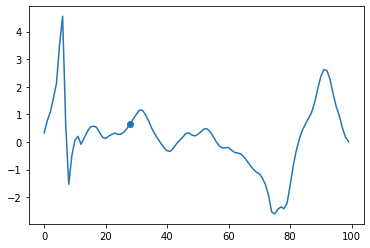

In [628]:
plt.plot(epoch1[3950:4050])
plt.scatter(28, epoch1[3978])
np.diff(epoch1[3956:3958])[0] > np.max(epoch1) * .05

### 1. Patient-Run Definition and Data Loading

#### Print available runs for subject and settings-version

In [10]:
# Explore available preprocessed runs
sub='008'
version='v2.0_Mar22'

importlib.reload(read_data)
read_data.show_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
)


### SHOW RUNS ###
For subject 008, in preproc-version v2.0_Mar22 are available:

LFP_LEFT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa10']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa50']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']

LFP_RIGHT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['

#### Select and Load in runs to explore


Not defining task, acquisition or group results in selecting all available options

In [11]:
# Select runs to explore/ ft-extract
importlib.reload(read_data)
fsel, groups, fdir = read_data.select_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
    sess_incl=['EcogLfpMedOn02'],
    tasks_incl=['SelfpacedHandTapL', 'Rest'],
    # acqs_incl=[
    # #     'StimOffDopa00',
    #     'StimOffDopa15',
    #     # 'StimOffDopa35',
    # #     'StimOffDopa50',
    # ],
    # groups_incl=['LFP_RIGHT', 'LFP_LEFT', 'ECOG'],  # if not given, all groups are included
)
# print and check selected runs
print(fsel)

['008_EcogLfpMedOn02_Rest_StimOffDopa00_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa60_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa30_1_v2.0_MAR22_LFP_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v2.0_MAR22_ECOG_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa10_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v2.0_MAR22_ACC_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa30_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa00_1_v2.0_MAR22_ACC_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa10_1_v2.0_MAR22_ECOG_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa30_1_v2.0_MAR22_ACC_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa50_1_v2.0_MAR22_LFP_LEFT_PREPROC_da

In [12]:
# Create dataclass per session
# session-dataclass wil contain dict with dataclasses containing
# data per run
importlib.reload(read_data)
SUB08 = read_data.SessionData(fsel, fdir)


In [ ]:
'''
PM: CREATE CLASS WITH WINDOWED FEATURES (EVERY 0.5 / 1 SEC, WITH 50% OVERLAP)

- WINDOWING BASED ON CURRENT SAMPLE-FREQ OF DATATYPE
- IN FT EXTRACTION PROCESS: ADDITIONAL FILTERING BEFORE WINDOWING!
- ADD CLASS WITH VIDEO-BASED EVENT RECOGNITION
    - dysk occurence:
        - coded for bodypart
        - coded for severity?
    - normal movement?
'''

#### Manual Video-Movement Annotation

In [37]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


#### Automated Acc-based Tap detection incl. plotting

In [13]:
SUB08.runs_incl

['Rest_StimOffDopa00',
 'SelfpacedHandTapL_StimOffDopa60',
 'Rest_StimOffDopa30',
 'SelfpacedHandTapL_StimOffDopa35',
 'Rest_StimOffDopa10',
 'Rest_StimOffDopa50',
 'SelfpacedHandTapL_StimOffDopa15']

In [15]:
importlib.reload(handTap_detect)
importlib.reload(handTap_detect2)


<module 'lfpecog_features.handTap_detect2' from '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/lfpecog_features/handTap_detect2.py'>

In [23]:
maxVar = np.argmax(stats.variation(SUB08.runs['SelfpacedHandTapL_StimOffDopa60'].acc_right_arr[:, :].T))
maxRMS = np.argmax(sum((SUB08.runs['SelfpacedHandTapL_StimOffDopa60'].acc_right_arr[:, :].T) ** 2))
if maxVar == maxRMS:
    mainAxis = maxVar
else:
    print(f'max variation ({maxVar}) and RMS ({maxRMS}) are not in same axis')

print(mainAxis)

max variation (2) and RMS (0) are not in same axis
1


In [54]:
SUB08.runs_incl

['Rest_StimOffDopa00',
 'SelfpacedHandTapL_StimOffDopa60',
 'Rest_StimOffDopa30',
 'SelfpacedHandTapL_StimOffDopa35',
 'Rest_StimOffDopa10',
 'Rest_StimOffDopa50',
 'SelfpacedHandTapL_StimOffDopa15']

In [228]:
np.argmax([stats.variation(d) for d in [xEpoch, yEpoch, zEpoch]])

1

In [221]:
# for run in runs:
tapDetector(
    fs = SUB08.runs[run].acc_left_Fs,
    x = SUB08.runs[run].acc_right_arr[1, :],
    y = SUB08.runs[run].acc_right_arr[2, :],
    z = SUB08.runs[run].acc_right_arr[3, :],
)

array([0.00000e+00, 5.00000e-03, 1.00000e-02, ..., 1.96340e+02,
       1.96345e+02, 1.96350e+02])

In [220]:
### FINGERTAP DETECTOR

### INCLUDE BILATERALITY FOR ACCELEROMETER
# run = 'SelfpacedHandTapL_StimOffDopa60'

to_plot = False
to_save = False

for run in SUB08.runs_incl:
    # if run[-2:] in ['00',]: continue
    print(f'start {run}')
    fs = SUB08.runs[run].acc_left_Fs
    timeStamps = SUB08.runs[run].acc_right_arr[0, :]
    xEpoch = SUB08.runs[run].acc_right_arr[1, :]
    yEpoch = SUB08.runs[run].acc_right_arr[2, :]
    zEpoch = SUB08.runs[run].acc_right_arr[3, :]

    # Determine axis of interest (most up-down movement)
    maxVar = np.argmax(stats.variation(SUB08.runs[run].acc_right_arr[1:, :].T))
    maxRMS = np.argmax(sum((SUB08.runs[run].acc_right_arr[1:, :].T) ** 2))
    mainAxis = maxVar
    if maxVar != maxRMS: print('Axis with most Variance does not have most RMS')
    nameAx = SUB08.runs[run].acc_right_names[mainAxis + 1]
    print(f'\nChosen Axis is {nameAx}')
    # couple acc-axis to use to mainAxis

    # Peak detections
    smallPos = signal.find_peaks(
        yEpoch,
        height=(np.max(yEpoch) * .1, np.max(yEpoch) * .6),  # first value is min, second is max
        distance=fs * .2,  # 1 s
        prominence=np.max(yEpoch) * .1,
        wlen=fs * .5,

    )
    largePos = signal.find_peaks(
        yEpoch,
        height=np.max(yEpoch) * .5,
        distance=fs,  # 1 s
    )
    smallNeg = signal.find_peaks(
        -1 * yEpoch,
        height=(-.5e-7, abs(np.min(yEpoch)) * .4),  # was: (abs(np.min(yEpoch)) * .05, abs(np min(yEpoch)) * .4)
        distance=fs * 0.2,  # 10 ms
        prominence=abs(np.min(yEpoch)) * .05,
        # wlen=40,
    )
    largeNeg = signal.find_peaks(
        -1 * yEpoch,
        height=abs(np.min(yEpoch)) * .4,  # first value is min, second is max
        distance=fs * .5,  # 10 ms
        # prominence=np.min(yEpoch) * .1,
        # wlen=40,
    )

    # handTap timing detect
    posThr = .5e-7  # adjust to person or tasks??!!
    negThr = -.5e-7
    tapTimes = []  # list to store timeStamps of tap
    moveTimes = []  # alternative list for movements
    restTimes = []  # list to sore rest-timestamps
    tapi = []  # list to store indices of tap
    movei = []  # list to store indices of other move
    resti = []  # list to store indices of rest
    resttemp = []  # list to temporarily collect rest-indices
    tempi = []  # for during detection process
    state = 'lowRest'
    for n, y in enumerate(yEpoch):

        if state == 'otherMov':
            if np.logical_and(
                y > posThr,
                any([Y in smallPos[0] for Y in range(n, n + int(fs * .2))])
            ):  # from other Movement into tap-begin
                tempi = []  # start new index list
                state='upAcc1'
                tempi.append(n)  # START TIME Tap-UP
                continue

            try:
                next10 = sum([negThr < Y < posThr for Y in yEpoch[range(
                    n, n + int(fs * .2)
                )]])
                if next10 > (fs * .2) * .8:  # if 8 out of next-10 y-values are inactive
                    tempi.append(n)  # END of OTHER MOVE
                    if (tempi[-1] - tempi[0]) > fs * .1:
                        movei.append(tempi)
                    tempi = []
                    state = 'lowRest'
            except IndexError:
                # print('end of timeseries')
                continue

        elif state == 'lowRest':
            if np.logical_and(
                y > posThr,
                any([Y in smallPos[0] for Y in range(n, n + int(fs * .2))])
            ):

                if resttemp:  # close and store active rest period
                    resttemp.append(n)  # Add second and last rest-ind
                    if (resttemp[1] - resttemp[0]) > fs:  # if rest > 1 sec
                        resti.append(resttemp)  # add finished rest-indices
                    resttemp = []  # reset resttemp list
                
                state='upAcc1'
                tempi.append(n)  # START TIME Tap-UP

            elif np.logical_or(
                    np.logical_or(n in smallPos[0], n in smallNeg[0]),
                    ~ (negThr < y < posThr)
            ):

                if resttemp:  # close and store active rest period
                    resttemp.append(n)  # Add second and last rest-ind
                    if (resttemp[1] - resttemp[0]) > fs:  # if rest > 1 sec
                        resti.append(resttemp)  # add finished rest-indices
                    resttemp = []  # reset resttemp list

                state = 'otherMov'
                tempi.append(n)  # START TIME Othermovement
            
            else:  # lowRest stays lowRest
                if not resttemp:  # if rest-temp list is empty
                    resttemp.append(n)  # start of rest period
                
        elif state == 'upAcc1':
            if n in smallPos[0]:
                state='upAcc2'  # after acc-peak, movement still accelerating
                # print('peakpos1', n)
        elif state == 'upAcc2':
            if y < 0:   #negThr < y < posThr:
                state='upDec1'
        elif state=='upDec1':
            if n - tempi[0] > (fs * 2):  # if movement-up takes > 2 sec
                state = 'otherMov'  # reset to start-state
                movei.append(tempi)  # was untoggled?
                tempi = []  # was untoggled?
            elif n in smallNeg[0]:
                state='upDec2'
                # print('peakneg1', n)
        elif state == 'upDec2':
            if y > 0:  #negThr < y < posThr:
                state='highRest'
                tempi.append(n)  # end of Up
                # print('endUP', n)
        elif state == 'highRest':
            if n - tempi[1] > (fs * 2):  # if highrest takes > 2 sec
                state = 'otherMov'  # reset to start-state
                movei.append(tempi)  # was untoggled?
                tempi = []  # was untoggled?
            elif np.logical_and(
                y < negThr,
                any([Y in largeNeg[0] for Y in range(n, n + int(fs * .2))])
            ):
                state='downAcc1'
                tempi.append(n)  # start of Tap-DOWN

        elif state == 'downAcc1':
            if n in largeNeg[0]:
                state='downAcc2'
            elif n - tempi[2] > (fs * 2):  # if down-move takes > 2 sec
                state = 'otherMov'  # reset to start-state
                movei.append(tempi)  # newly added
                tempi = []  # newly added

        elif state == 'downAcc2':
            if np.logical_or(
                negThr < y < posThr,
                y > posThr
            ):
                state='downDec1'
            elif n - tempi[2] > (fs * 2):  # if down-move takes > 2 sec
                state = 'otherMov'  # reset to start-state
                movei.append(tempi)  # newly added
                tempi = []  # newly added
                
        elif state=='downDec1':
            if n in largePos[0]:
                state='downDec2'
            elif n - tempi[2] > (fs * 2):  # if down-move takes > 2 sec
                state = 'otherMov'  # reset to start-state
                movei.append(tempi)  # newly added
                tempi = []  # newly added
                
        elif state == 'downDec2':
            if negThr < y < posThr:
                state='lowRest'
                tempi.append(n)  # end of DOWN
                tapi.append(tempi)
                tempi = []

    # remove otherMovements directly after tap
    if tapi and movei:  # only when both exist
        endTaps = [tap[-1] for tap in tapi]
        movei_sel = []
        for tap in movei:
            if min([abs(tap[0] - end) for end in endTaps]) > (.25 * fs):
                movei_sel.append(tap)
        movei = movei_sel

    # convert detected indices-lists into timestamps
    for tap in tapi: tapTimes.append(timeStamps[tap])
    for tap in movei: moveTimes.append(timeStamps[tap])
    for tap in resti: restTimes.append(timeStamps[tap])

    ### Saving Rest Blocks
    for neusource in ['lfp_left', 'ecog', 'lfp_right']:
        SelAndSave_Restblocks(
            neu_data = getattr(SUB08.runs[run], f'{neusource}_arr'),
            fs = getattr(SUB08.runs[run], f'{neusource}_Fs'),
            neu_names = getattr(SUB08.runs[run], f'{neusource}_names'),
            restTimes=restTimes,
            runname=run[-6:], neu_ch_incl=['ECOG_L_1', 'LFP_L_3_4']
        )

    ### PLOTTING ###
    if to_plot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        ax.plot(xEpoch, label='x', alpha=.5, c='blue')
        ax.plot(yEpoch, label='y', alpha=.8, c='green')
        ax.plot(zEpoch, label='z', alpha=.5, c='orange')
        # plot vertical lines at tap-moments
        for t, tap in enumerate(tapi):
            if t == 0:
                ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
                ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
                ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
                ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
            else:
                ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
                ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
                ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
                ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

        peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
        peakcol = ['lightgreen', 'green', 'orange', 'r']
        for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
            ax.scatter(
                peaks[0],
                yEpoch[peaks[0]],
                label=peaklabel[p],
                color=peakcol[p],
                s=50,
            )
        
        for mov in movei:  # check saved otherMovements
            ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
            ax.axvline(mov[-1], color='gray', lw=1)

        # ax.axhline(-.5e-7)
        ax.axhline(posThr)
        ax.axhline(0, c='gray', lw=.5,)
        # determine what to show
        ax.set_ylim(-2.5e-6, 2.5e-6)
        # ax.set_xlim(istart, istop)
        ax.set_xlim(0, 30000)
        # ax.set_xticks(np.arange(18600, 20001, 200))
        # ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)

        ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
        ax.set_xlabel('Time (s)', size=14)

        ax.set_title(run)

        # ax.legend(frameon=False, fontsize=14, loc='upper right')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Plot Rest-moments
        for idx in resti:
            ax.fill_betweenx(
                y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
                color='blue', alpha=.1,)

        if to_save:
            plt.savefig(
                os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}'),
                dpi=300, facecolor='w',
            )
        plt.close()

        print(f'{run} finisihed')

start Rest_StimOffDopa00

Chosen Axis is ACC_R_Y
LFP_L_0_1
LFP_L_1_2
LFP_L_2_3
LFP_L_3_4
ECOG_L_1
ECOG_L_2
ECOG_L_3
ECOG_L_4
ECOG_L_5
ECOG_L_6
LFP_R_0_1
LFP_R_1_2
LFP_R_2_3
LFP_R_3_4
LFP_R_4_5
start SelfpacedHandTapL_StimOffDopa60

Chosen Axis is ACC_R_Y
LFP_L_0_1
LFP_L_1_2
LFP_L_2_3
LFP_L_3_4
ECOG_L_1
ECOG_L_2
ECOG_L_3
ECOG_L_4
ECOG_L_5
ECOG_L_6
LFP_R_0_1
LFP_R_1_2
LFP_R_2_3
LFP_R_3_4
LFP_R_4_5
start Rest_StimOffDopa30

Chosen Axis is ACC_R_Y
LFP_L_0_1
LFP_L_1_2
LFP_L_2_3
LFP_L_3_4
ECOG_L_1
ECOG_L_2
ECOG_L_3
ECOG_L_4
ECOG_L_5
ECOG_L_6
LFP_R_0_1
LFP_R_1_2
LFP_R_2_3
LFP_R_3_4
LFP_R_4_5
start SelfpacedHandTapL_StimOffDopa35

Chosen Axis is ACC_R_Y
LFP_L_0_1
LFP_L_1_2
LFP_L_2_3
LFP_L_3_4
ECOG_L_1
ECOG_L_2
ECOG_L_3
ECOG_L_4
ECOG_L_5
ECOG_L_6
LFP_R_0_1
LFP_R_1_2
LFP_R_2_3
LFP_R_3_4
LFP_R_4_5
start Rest_StimOffDopa10
Axis with most Variance does not have most RMS

Chosen Axis is ACC_R_Z
LFP_L_0_1
LFP_L_1_2
LFP_L_2_3
LFP_L_3_4
ECOG_L_1
ECOG_L_2
ECOG_L_3
ECOG_L_4
ECOG_L_5
ECOG_L_6
LFP_R_0_1
LF

In [231]:
moveTimes

[array([2.61 , 3.285]),
 array([76.12, 76.7 ]),
 array([104.665, 105.51 ]),
 array([108.38, 109.03]),
 array([112.94, 113.82]),
 array([138.12, 138.46]),
 array([140.69 , 141.625]),
 array([153.67 , 153.835]),
 array([181.02 , 181.835])]

In [64]:
tempdir = ('/Users/jeroenhabets/Research/CHARITE/projects/'
    'dyskinesia_neurophys/data/analysis_derivatives/sub-008/May03')


In [219]:
def SelAndSave_Restblocks(
    neu_data, fs, neu_names, restTimes, runname, winlen=1024,
    neu_ch_incl=[],
):
    for neu_chi in np.arange(1, neu_data.shape[0]):
        neudat = neu_data[neu_chi, :]
        neuTimes = neu_data[0, :]
        neu_ch = neu_names[neu_chi]  # channel name
        print(neu_ch)
        if neu_ch_incl:
            if neu_ch not in neu_ch_incl: continue

        tempdat = np.zeros((1, winlen))
        rowTimes = []  # list to store times corresponding to data rows

        for n, timeIdx in enumerate(restTimes[1:-1]):  # skip first and last
            neuInd1 = np.where(neuTimes == timeIdx[0])[0][0]
            neuInd2 = np.where(neuTimes == timeIdx[1])[0][0]
            dat_sel = neudat[neuInd1:neuInd2]
            n_wins = len(dat_sel) // winlen
            dat_sel = np.reshape(
                dat_sel[:n_wins * winlen],
                (n_wins, winlen),
                order='C',  # fills row after row
            )
            tempdat = np.vstack([tempdat, dat_sel])
            for i in np.arange(n_wins):
                rowTimes.append(timeIdx[0] + (i * winlen / fs))

        rowTimes = np.round(rowTimes, 3)  # round .019999 values
        tempdat = tempdat[1:, :]  # exclude first row of zeros

        # saving data array
        fname = f'{runname}_{neu_ch}_win{winlen}'
        # np.save(os.path.join(
        #     tempdir, 'restblocks', f'restBlocks_sub08_{fname}'), tempdat)
        # save list of rowtimes
        np.save(os.path.join(
            tempdir, 'restblocks', f'restTimes_sub08_{fname}'), rowTimes)


    # return tempdat, rowTimes

In [179]:
import csv

In [201]:
a[[1,2,0], :]

array([[ 3,  1,  1,  1],
       [-4,  1,  1,  1],
       [ 1,  1,  1,  1]])

In [206]:
a = np.array([
    [1,1,1,1],
    [3,1,1,1],
    [-4,1,1,1],
])
s = np.argsort(a[:, 0], )
a[s]

array([[-4,  1,  1,  1],
       [ 1,  1,  1,  1],
       [ 3,  1,  1,  1]])

In [165]:
neusource = 'lfp_left'
_, _ = SelAndSave_Restblocks(
    neu_data = getattr(SUB08.runs[run], f'{neusource}_arr'),
    fs = getattr(SUB08.runs[run], f'{neusource}_Fs'),
    neu_names = getattr(SUB08.runs[run], f'{neusource}_names'),
    restTimes=restTimes,
    runname=run[-6:],
)

In [171]:
f, psd = signal.welch(neudat[:1024], fs=800)

In [178]:
type(neudat[10])

numpy.float64

### OLD HANDTAP DETECT

In [272]:
importlib.reload(handTap_detect)
# define file with manual video-annotations
tap_ann_file = os.path.join(
    projectpath, 'data', 'analysis_derivatives', 'sub-008',
    'taps', '008_video_ann_tapruns.npy')
# run function
blocks = handTap_detect.handTapDetector(
    SubClass=SUB08,
    check_plots=False,
    # check_plots=False,
    runs_excl=[
#         'Rest_StimOffDopa00', 'Rest_StimOffDopa30',
#  'SelfpacedHandTapL_StimOffDopa35',
#  'Rest_StimOffDopa10',
#  'Rest_StimOffDopa50',
#  'SelfpacedHandTapL_StimOffDopa15'
    ],
    plotdir=os.path.join(temp_save, 'ACC'),
    plot_annot=tap_ann_file,
    buffsec=.05,
    TAPthr=2e-7,
    MOVthr=1e-7,
    savedir=os.path.join(
        projectpath, f'data/preprocess/sub-{sub}/'
        f'/acc/acc_taps_sub{sub}'),
)


Start Rest_StimOffDopa00

Start SelfpacedHandTapL_StimOffDopa60

Start Rest_StimOffDopa30

Start SelfpacedHandTapL_StimOffDopa35

Start Rest_StimOffDopa10

Start Rest_StimOffDopa50

Start SelfpacedHandTapL_StimOffDopa15


In [267]:
for run in [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]:
    print(run)
    for side in ['left', 'right']:
        print([len(blocks[run][side]['Taps'][k]) for k in
            blocks[run][side]['Taps']])

SelfpacedHandTapL_StimOffDopa15
[130, 124, 116, 130, 110, 94, 76, 111, 76, 79, 77, 99, 87, 84, 87, 91]
[137, 168, 116, 137, 126, 128, 95, 113, 114, 122, 118, 120, 116, 120, 92]
SelfpacedHandTapL_StimOffDopa35
[107, 111, 102, 82, 84, 88, 78, 99, 103, 166, 119, 60, 99, 113]
[128, 178, 122, 97, 129, 100, 110, 116, 118, 171, 66, 101, 188, 156, 131, 123, 167]
SelfpacedHandTapL_StimOffDopa60
[162, 130, 116, 105, 116, 115, 109, 94, 117, 137, 114, 100, 116, 74, 112]
[165, 165, 138, 149, 118, 139, 132, 132, 127, 123, 116, 175, 121, 146, 142]


In [177]:
a = np.array([5555 , 6600, 7000])
a / 200

array([27.775, 33.   , 35.   ])

In [263]:
# Plot figures to check identified acticity blocks per block

blockdict = blocks
for run in [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]:
    nrows=20
    thr = 5e-7
    fig, axes = plt.subplots(nrows, 2, figsize=(16,12),
        sharey='row',)
    # axes = axes.flatten()
    ls = {'left': 'solid', 'right': 'dotted'}
    state='Taps'
    xdiff = 100

    for s, accside in enumerate(['left', 'right']):
        runclass = SUB08.runs[run]
        acc_svm = np.sqrt(
            getattr(runclass, f'acc_{accside}_arr')[1, :]**2 +
            getattr(runclass, f'acc_{accside}_arr')[2, :]**2 +
            getattr(runclass, f'acc_{accside}_arr')[3, :]**2
        )

        for b in np.arange(nrows):
            try:
                acc0 = int(blockdict[run][accside][state][b][0] * 200)
            except KeyError:
                for sp in ['left', 'right', 'top', 'bottom']:
                    axes[b, s].spines[sp].set_visible(False)
                axes[b, s].set_ylabel(f'{b}', size=14)
                axes[b, s].set_xticks([])
                axes[b, s].set_yticks([])
                continue
            acc1 = int(blockdict[run][accside][state][b][-1] * 200)
            axes[b, s].plot(acc_svm[acc0 - xdiff:acc1 + xdiff],
                alpha=.5, label=accside)
            axes[b, s].axvline(x=xdiff)
            axes[b, s].axvline(x=xdiff + acc1 - acc0)
            axes[b, s].set_yticklabels([])
            if s == 0: axes[b, s].set_ylabel(f'{b}', size=14)
            for a in ['right', 'top']:
                axes[b, s].spines[a].set_visible(False)
        axes[0, s].set_title(f'{accside.upper()}', size=14)

    plt.suptitle(run, color='gray', size=14)
    plt.tight_layout(h_pad=0.0, w_pad=0.0)
    fig.savefig(os.path.join(
        temp_save, 'ACC',
        f'single_{state}_sub08_{run[-6:]}_LR_v4'
    ), dpi=150, facecolor='w',)
    plt.close()

    #### TODO:
    ### New Tap detection:
    ## USE Y-axis
    ## SEARCH for double sinusoid for one tap (+ - - +)
    #   one sinusoid (+ -) is raising hand
    #   one sinusoid (- +) is lowering hand
    # PM: use impact-artifact as backup-tap detection
    # - SPLIT THRESHOLDS FOR TAP DETECT VS DYSK/ELSE DETECT
    # - ANNOTATE VIDEO WITH DYSKINETIC MOVEMENTS TO CHECK NEW ALGORITHM

In [ ]:
'''
IMPORTANT: CHECK VIDEO - TMSi TIME DIFF
# second left-mov (tap) in video at 19:19
# -> video Timestamp('2021-11-15 11:45:20')
# -> acc from 2021-11-15 11:48:19.395000 
#           to 2021-11-15 11:48:20.300000

# first right-mov (dysk) in video at 19:14
#  -> video Timestamp('2021-11-15 11:47:00')
#  -> acc from 2021-11-15 11:48:14.505000
#           to 2021-11-15 11:48:16.040000

# Rest recording starts in video at 12:52
# -> video first movements right between 13:00 +/- 00:02:
#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02
# IN ACC: 11:42:00 +/- 00:02
# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video

## TODO / Finish:
- PREPROC: INCLUDE TIME (t) and TimeSTAMPS (ts) to arrays
- PREPROC: downssample to higher freq for short term analyssi
- differentiation in algorithm between dyskinetic movement and tap
- test algorithm on different Subjects

